# ШИФТ Курс "Аплифт"

## Задача: Предсказать, кому отправить СМС, чтобы склонить к покупке.

Есть данные о том, кто из клиентов именно тот, кто без СМС не купит, а с СМС - купит! Необходимо из всех test-клиентов указать вероятность того, что клиент купит только при коммуникации (не купит без нее).

Последовательность решения задачи:
1. Загрузка и первичный анализ данных.
2. Подготовка данных.
3. Построение модели.
4. Проверка модели на тестовой выборке.
5. Вывод

In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier

import scipy
from scipy.sparse import *
from scipy import stats

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from tsfresh import extract_features, select_features
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/uplift-shift-23/baseline.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/train_purch/train_purch.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/data/products.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/data/clients2.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/data/train.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/data/test.csv
/kaggle/input/uplift-shift-23/x5-uplift-valid/test_purch/test_purch.csv


In [2]:
# Установка библиотеки `scikit-uplift`
!{sys.executable} -m pip install scikit-uplift catboost pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.3 MB/s eta 0:00:00


In [3]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels

In [4]:
pd.set_option('display.max_columns', None)

## 1. Загрузка данных и первичный анализ данных.

Загрузим данные и определим колонки в которых содержется дата и время.

In [5]:
# Загрузка данных
df_client = pd.read_csv('/kaggle/input/uplift-shift-23/x5-uplift-valid/data/clients2.csv', 
                        parse_dates=['first_issue_date','first_redeem_date'])
df_products = pd.read_csv('/kaggle/input/uplift-shift-23/x5-uplift-valid/data/products.csv')
df_train_purch = pd.read_csv('/kaggle/input/uplift-shift-23/x5-uplift-valid/train_purch/train_purch.csv',
                             parse_dates=['transaction_datetime'])
df_test_purch = pd.read_csv('/kaggle/input/uplift-shift-23/x5-uplift-valid/test_purch/test_purch.csv',
                            parse_dates=['transaction_datetime'])
df_train_list = pd.read_csv('/kaggle/input/uplift-shift-23/x5-uplift-valid/data/train.csv')
df_test_list = pd.read_csv('/kaggle/input/uplift-shift-23/x5-uplift-valid/data/test.csv')

### 1.1. Анализ данных о клиентах.

In [6]:
df_client.head()

,client_id,client_id.1,first_issue_date,first_redeem_date,age,gender
0,000012768d,NaN,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,NaN,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,NaN,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
3,0001f552b0,NaN,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
4,00020e7b18,NaN,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U


In [7]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   client_id          200039 non-null  object        
 1   client_id.1        0 non-null       float64       
 2   first_issue_date   200039 non-null  datetime64[ns]
 3   first_redeem_date  182493 non-null  datetime64[ns]
 4   age                200039 non-null  int64         
 5   gender             200039 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 9.2+ MB


Видно, что колонка `client_id.1` пустая, имеются пропускив колонке `first_redeem_date`.

In [8]:
df_client.describe()

,client_id.1,age
count,0.0,200039.000000
mean,NaN,46.417329
std,NaN,49.532475
min,NaN,-7491.000000
25%,NaN,34.000000
50%,NaN,45.000000
75%,NaN,59.000000
max,NaN,1852.000000


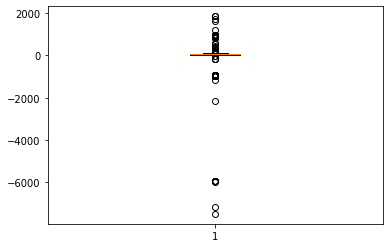

In [9]:
plt.boxplot(df_client['age']);

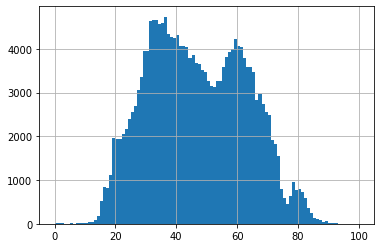

In [10]:
df_client[(df_client['age'] >= 0) & (df_client['age'] <=100)]['age'].hist(bins=100);

In [11]:
df_client[(df_client['age'] < 0) | (df_client['age'] > 100)]['age']

5         115
47        959
882       119
1179      108
1265      119
         ... 
198736    115
198928    931
199500    115
199557    119
199579    119
Name: age, Length: 577, dtype: int64

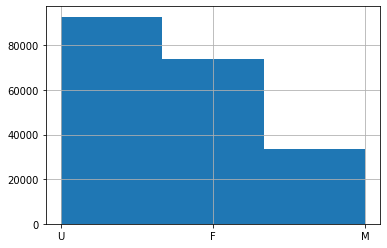

In [12]:
df_client['gender'].hist(bins=3);

In [13]:
print('min first_issue_date =', df_client['first_issue_date'].min())
print('max first_issue_date =', df_client['first_issue_date'].max())
print('min first_redeem_date =', df_client['first_redeem_date'].min())
print('max first_redeem_date =', df_client['first_redeem_date'].max())

min first_issue_date = 2017-04-04 18:24:18
max first_issue_date = 2019-03-15 21:44:14
min first_redeem_date = 2017-04-11 09:42:20
max first_redeem_date = 2019-11-20 01:14:10


**Вывод:**

В наборе данных содержится информация о 200039 клиентах. Пол клиентов распределён следующим образом: женщин больше чем мужчин в два раза, однако клиентов о поле которых не известно - примерно 50%. Большая часть клиентов имеет возраст от 20 до 75 лет. Медианный возраст клиентов составляет 45 лет. Дата регистрации клиентов лежит в диапозоне апрель 2017г.- март 2019г., а даты погашения с апреля 2017г. по ноябрь 2019г.
В данных о клиентах имеются следующие проблемные вопросы:
1. Колонка `client_id.1` пустая.
2. Пропуски в колонке `first_redeem_date`
3. В колонке `age` встречаются недостоверные данные о возрасте(577 шт.).


### 1.2. Анализ данных о товарах.

In [14]:
df_products.head()

,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
0,0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123.0,394a54a7c1,9eaff48661,0.400,0,0
1,0003870676,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,acd3dd483f,10486c3cf0,0.680,0,0
2,0003ceaf69,c3d3a8e8c6,f2333c90fb,419bc5b424,f6148afbc0,271.0,f597581079,764e660dda,0.500,0,0
3,000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,54a90fe769,03c2d70bad,0.112,0,0
4,0007149564,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,63417fe1f3,f329130198,0.600,0,0


In [15]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43038 entries, 0 to 43037
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_id        43038 non-null  object 
 1   level_1           43035 non-null  object 
 2   level_2           43035 non-null  object 
 3   level_3           43035 non-null  object 
 4   level_4           43035 non-null  object 
 5   segment_id        41466 non-null  float64
 6   brand_id          37838 non-null  object 
 7   vendor_id         43004 non-null  object 
 8   netto             43035 non-null  float64
 9   is_own_trademark  43038 non-null  int64  
 10  is_alcohol        43038 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 3.6+ MB


In [16]:
df_products.describe()

,segment_id,netto,is_own_trademark,is_alcohol
count,41466.000000,43035.000000,43038.000000,43038.000000
mean,153.918222,0.536966,0.035178,0.055602
std,82.271376,8.274367,0.184232,0.229154
min,1.000000,0.000000,0.000000,0.000000
25%,105.000000,0.150000,0.000000,0.000000
50%,148.000000,0.300000,0.000000,0.000000
75%,214.000000,0.500000,0.000000,0.000000
max,321.000000,1150.000000,1.000000,1.000000


<AxesSubplot:>

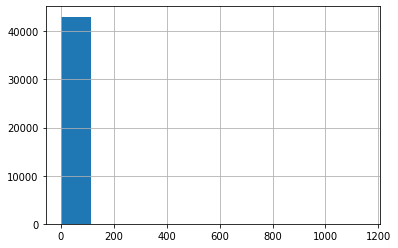

In [17]:
df_products['netto'].hist()

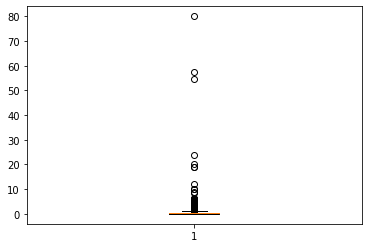

In [18]:
plt.boxplot(df_products[df_products['netto'] < 100]['netto']);

**Вывод:**

В данном наборе данных, соделжится информация о 43038 товарах. По каждому товару представлена информацию о его бренде, поставщике, сегменте, весе, флаги принадлежности к товарам собственного производства и принадлежности к алкогольной продукции.

Выявлены следующие проблемные моменты:
1. Пропуски в колонках: `level_1`,`level_2`,`level_3`,`level_4`,`segment_id`, `brand_id`, `vendor_id`, `netto`.
2. Вес товара в колонке `netto`, видимо, представлен как в килограммах так и в граммах. Необходимо привести к единому представлению

### 1.3. Анализ данныех о продажах.

In [19]:
df_train_purch.head(20)

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN
5,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,21db5dbe53,1.0,34.0,NaN
6,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,1e208d0b4c,1.0,24.0,NaN
7,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,15ccaa8685,1.0,51.0,NaN
8,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,45389bb5b0,1.0,23.0,NaN
9,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,cb4c804130,1.0,60.0,NaN


In [20]:
df_test_purch.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,a375a035b9,2.0,50.0,NaN
1,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,6f9e02ee36,1.0,90.0,NaN
2,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,42e1eb8d23,1.0,20.0,NaN
3,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,5c6de3010f,2.0,85.0,NaN
4,00010925a5,e91ffe5b50,2018-11-25 10:56:18,1.5,0.0,0.0,0.0,303.0,76d287ce03,343e841aaa,1.0,58.0,NaN


In [21]:
df_train_purch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15998952 entries, 0 to 15998951
Data columns (total 13 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   client_id                object        
 1   transaction_id           object        
 2   transaction_datetime     datetime64[ns]
 3   regular_points_received  float64       
 4   express_points_received  float64       
 5   regular_points_spent     float64       
 6   express_points_spent     float64       
 7   purchase_sum             float64       
 8   store_id                 object        
 9   product_id               object        
 10  product_quantity         float64       
 11  trn_sum_from_iss         float64       
 12  trn_sum_from_red         float64       
dtypes: datetime64[ns](1), float64(8), object(4)
memory usage: 1.5+ GB


In [22]:
df_test_purch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6883738 entries, 0 to 6883737
Data columns (total 13 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   client_id                object        
 1   transaction_id           object        
 2   transaction_datetime     datetime64[ns]
 3   regular_points_received  float64       
 4   express_points_received  float64       
 5   regular_points_spent     float64       
 6   express_points_spent     float64       
 7   purchase_sum             float64       
 8   store_id                 object        
 9   product_id               object        
 10  product_quantity         float64       
 11  trn_sum_from_iss         float64       
 12  trn_sum_from_red         float64       
dtypes: datetime64[ns](1), float64(8), object(4)
memory usage: 682.7+ MB


In [23]:
df_train_purch.isna().sum()

client_id                         0
transaction_id                    0
transaction_datetime              0
regular_points_received           0
express_points_received           0
regular_points_spent              0
express_points_spent              0
purchase_sum                      0
store_id                          0
product_id                        0
product_quantity                  0
trn_sum_from_iss                  0
trn_sum_from_red           14943088
dtype: int64

In [24]:
df_train_purch['trn_sum_from_red'].value_counts()

5.0       41782
40.0      36453
50.0      35020
60.0      33742
30.0      29097
          ...  
1223.0        1
1266.0        1
925.0         1
1116.0        1
3078.0        1
Name: trn_sum_from_red, Length: 1108, dtype: int64

In [25]:
df_test_purch['trn_sum_from_red'].value_counts()

5.0       18098
40.0      15830
50.0      15274
60.0      14928
30.0      12550
          ...  
1292.0        1
1935.0        1
1236.0        1
744.0         1
605.0         1
Name: trn_sum_from_red, Length: 943, dtype: int64

In [26]:
df_train_purch['transaction_id'].unique().shape

(2814993,)

In [27]:
df_test_purch['transaction_id'].unique().shape

(1209951,)

**Вывод:**

В наборе данных, содержится информация о 16 миллионах проданных товарах в 2.8 миллионах транзакций в тренировочных данных и 7 миллионах проданных товарах в 1,2 миллионах транзакций в тестовых данных.

Проблемные вопросы в данных:
1. Пропуски в колонке `trn_sum_from_red`

**Вывод по разделу** 

В результате разведочного анализа, мы получили общие сведенья о представленных данных и о проблемных моментах, которые необходимо будет решить на этапе предобработки данных. 

1. Данные о клиентах:
    - Колонка `client_id.1` пустая.
    - Пропуски в колонке `first_redeem_date`
    - В колонке `age` встречаются недостоверные данные о возрасте(577 шт.).
2. Данные о товарах:
    - Пропуски в колонках: `level_1`,`level_2`,`level_3`,`level_4`,`segment_id`, `brand_id`, `vendor_id`, `netto`.
    - Вес товара в колонке `netto`, видимо, представлен как в килограммах так и в граммах. Необходимо привести к единому представлению
3. Данные о продажах:
    - Пропуски в колонке `trn_sum_from_red`

## 2. Подготовка данных
1. Выполним предобработку данных.
2. Извлечём признаки.
3. Сформируем выборки для обучения модели.


### 2.1 Предобработка данных

1. В таблице с данными о клиентах:
    - Возраст клиентов - пропуски заменим на медианный возраст.
    - Удалим пустую колонку `client_id.1`.
    - Преобразуем данные в колонке `gender` к целочисленному типу.
    - Преобразуем данные в колонках `first_issue_date` и `first_redeem_time` к формату timestamp. Также, создадим признак `issue_redeem_delay`, который будет равен разности между признаками`first_issue_date` и `first_redeem_time`. Заполним пропуски в колонке `first_redeem_time` на основе данных из колонки `first_issue_date` и средней разности между ними.
2. В данных о продуктах:
    - заполним пропуски нулями
    - тип данных в колонке `segment_id` изменим на `int`
3. Данные о продажах:
    - заполним пропуски в колонке `trn_sum_from_red` нулями

<AxesSubplot:>

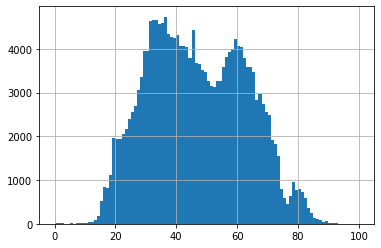

In [28]:
# Предобработка данных о клиентах
# Преобразуем выбросы возраста
df_client.loc[(df_client['age'] > 100) | (df_client['age'] < 0), 'age'] = df_client['age'].median()
# Удалим константную колонку
df_client = df_client.drop('client_id.1', axis=1)

df_client['age'].hist(bins=100)

In [29]:
# Преобразование данных о поле покупателей
gender = {
    'U':0,
    'F':1,
    'M':2
}
df_client['gender'] = df_client['gender'].apply(lambda x: gender[x])
df_client['gender'].unique()

array([0, 1, 2])

In [30]:
# Преобразование колонок содержащих даты
df_client['first_issue_time'] = (pd.to_datetime(df_client['first_issue_date']) 
                                 - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_client['first_redeem_time'] = (pd.to_datetime(df_client['first_redeem_date']) 
                                  - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_client['issue_redeem_delay'] = df_client['first_redeem_time'] - df_client['first_issue_time']

# Удалим исходные колонки
df_client = df_client.drop(['first_issue_date', 'first_redeem_date'], axis=1)
# # Заполним пропуски
df_client['issue_redeem_delay'] = df_client['issue_redeem_delay'].fillna(df_client['issue_redeem_delay'].mean())
df_client.loc[df_client['first_redeem_time'].isna(), 'first_redeem_time'] = \
    df_client.loc[df_client['first_redeem_time'].isna(), ['first_issue_time', 'issue_redeem_delay']].sum(axis=1)

In [31]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   client_id           200039 non-null  object 
 1   age                 200039 non-null  int64  
 2   gender              200039 non-null  int64  
 3   first_issue_time    200039 non-null  int64  
 4   first_redeem_time   200039 non-null  float64
 5   issue_redeem_delay  200039 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 9.2+ MB


In [32]:
# Сформируем список колонок строкового и численного типов
products_col_obj = [ j for i,j in zip(df_products.dtypes, df_products.dtypes.index) if i == 'O']
products_col_dig = [ j for i,j in zip(df_products.dtypes, df_products.dtypes.index) if i != 'O']

In [33]:
# Предобработка данных о товарах
df_products[products_col_obj] = df_products[products_col_obj].fillna('uncnown')
df_products[products_col_dig] = df_products[products_col_dig].fillna(0)
df_products['segment_id'] = df_products['segment_id'].astype(int)

In [34]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43038 entries, 0 to 43037
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   product_id        43038 non-null  object 
 1   level_1           43038 non-null  object 
 2   level_2           43038 non-null  object 
 3   level_3           43038 non-null  object 
 4   level_4           43038 non-null  object 
 5   segment_id        43038 non-null  int64  
 6   brand_id          43038 non-null  object 
 7   vendor_id         43038 non-null  object 
 8   netto             43038 non-null  float64
 9   is_own_trademark  43038 non-null  int64  
 10  is_alcohol        43038 non-null  int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 3.6+ MB


In [35]:
# Предобработка данных о транзакциях
df_train_purch['trn_sum_from_red'] = df_train_purch['trn_sum_from_red'].fillna(0)
df_test_purch['trn_sum_from_red'] = df_test_purch['trn_sum_from_red'].fillna(0)

**Вывод:** Предобработка выполнена.

### 2.2 Извлечение признаков

К имеемому набору данных мной были применены несколько подходов к извлечению признаков:
- Извлечение данных с помощью библиотеки tsfrash;
- Извлечение данных из элементов даты и времени покупок;
- Извлечение данных с помощью агрегации данных о покупаемых товарах;
- Работа с текстовыми признаками с их векторизацией;
- Работа с признаками как с временным рядом для каждого клиента.

Наилучший результат показал подход к преобразованию признаков как временному ряду по недельным тратам клиентов с добавлением некоторых признаков, полученных в результате агрегации данных о покупаемых товарах. Именно этот процесс будет реализован далее.

Последовательность извлечения признаков:
1. Объединим данные о транзакциях с данными о товарах в одну таблицу и агрегируем.
2. Извлечём признаки временных рядов с ресемплированием покупок по неделям.
3. Сформируем признаки для каждого покупателя на основе его транзакций.

#### 2.2.1 Объединение таблиц и агрегация данных

Объединим таблицу `df_train_purch` с таблицей `df_products`. Затем произведём агрегацию данных из полученных таблиц по транзакциям. Таким образом, в полученом датасете будут в каждой строке содержаться данные по отдельной транзакции с необходимыми нам данными.

In [36]:
# Объединение таблиц с тренировочными данными
df_train_purch = df_train_purch.merge(df_products)
# Объединение таблиц с тестовыми данными
df_test_purch = df_test_purch.merge(df_products)

In [37]:
# Определим словарь с данными для агрегации после группировки
group_dict = {
    'client_id':'first',
    'transaction_datetime': 'first',
    'purchase_sum': 'first',
#     'segment_id': pd.Series.mode,
#     'segment_id': lambda x: stats.mode(x)[0][0],
    'netto':'sum',
    'is_own_trademark':'sum',
    'is_alcohol':'sum',

}

In [38]:
%%time
# Агрегация данных
df_train_ex = df_train_purch.groupby('transaction_id').agg(group_dict)
df_test_ex = df_test_purch.groupby('transaction_id').agg(group_dict)
# Объеденим тренировчные и тестовые данные в один датасет для удобства дальнейшей работы
df_ex = pd.concat([df_train_ex, df_test_ex])
# Переименуем колонку
df_ex = df_ex.set_index('transaction_datetime')

df_train_ex.head()

CPU times: user 39.6 s, sys: 1.1 s, total: 40.7 s
Wall time: 40.7 s


,client_id,transaction_datetime,purchase_sum,netto,is_own_trademark,is_alcohol
transaction_id,,,,,,
0000033e06,42ea7275e0,2019-03-14 07:11:39,247.00,1.103,1,0
00001bd343,44903524e0,2019-01-07 18:57:44,285.94,2.355,2,0
0000349b45,1ad9152a20,2019-01-15 07:08:22,441.00,6.428,3,0
0000360c79,89a3ee6090,2019-02-14 11:29:36,320.00,4.200,1,0
000037ab38,823c39c6f5,2019-03-09 06:38:06,149.00,0.290,0,0


**Вывод:**

В результате произведённых преобразований, имеем набор необходимых данных по каждой транзакции.

### 2.2.2. Извлечение признаков временных рядов

Для каждого клиента произведём ресемплирование сумм покупок по неделям и рассчитаем среднюю величину еженедельных покупок

In [39]:
# Выделим номера недель
df_ex['week'] = df_ex.index.week
# Перенумеруем недели
df_ex['week'] = df_ex['week'].apply(lambda x: f'week_{12-x}' if x <= 12 else f'week_{64 - x}')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


In [40]:
%%time
# Рассчитаем траты для каждого клиента в неделю
df_ex_week = df_ex.groupby(['client_id','week'])['purchase_sum'].sum()
# Преобразуем в датафрейм
dr_resample = pd.DataFrame(df_ex_week)
dr_resample = dr_resample.reset_index()
dr_resample.head()

CPU times: user 3.18 s, sys: 233 ms, total: 3.42 s
Wall time: 3.42 s


,client_id,week,purchase_sum
0,000012768d,week_1,419.0
1,000012768d,week_14,574.0
2,000012768d,week_16,1007.0
3,000012768d,week_2,803.0
4,000036f903,week_1,329.0


In [41]:
def client_procesing(df):
    """ Принимаем датафрейм от групперовки по ИД клиентов
        Возвращаем строку содержащую информацию по всем неделям
    """
    
    df = df.set_index('week')['purchase_sum']
    line = pd.DataFrame()

    return line.append(df)

In [42]:
%%time
# Формируем датасет со сдвинутыми суммарными чеками по всем неделям
df_shift = dr_resample.groupby('client_id').apply(client_procesing)\
                .reset_index().drop(columns=['level_1']).set_index('client_id')
df_shift = df_shift.fillna(0)
df_shift.head()

CPU times: user 12min, sys: 6.04 s, total: 12min 6s
Wall time: 12min 7s


,week_1,week_14,week_16,week_2,week_10,week_12,week_13,week_15,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_17,week_11,week_0
client_id,,,,,,,,,,,,,,,,,,
000012768d,419.00,574.0,1007.00,803.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0
000036f903,329.00,564.0,241.00,511.0,641.00,637.00,1356.00,786.00,524.00,1420.00,984.00,669.00,432.00,497.00,214.0,0.00,0.0,0.0
00010925a5,0.00,0.0,132.00,1450.0,0.00,438.00,764.00,498.00,478.00,930.00,0.00,184.00,706.00,0.00,0.0,303.00,0.0,0.0
0001f552b0,1715.01,0.0,335.37,0.0,0.00,1332.42,0.00,586.94,22.00,474.36,0.00,448.86,206.96,113.37,0.0,919.89,0.0,0.0
00020e7b18,1642.33,0.0,2748.50,0.0,4205.61,0.00,891.85,2353.93,2430.61,2023.33,3656.53,1002.30,1070.85,1249.70,0.0,2544.07,0.0,0.0


In [43]:
# Средние траты в неделю
df_shift['mean'] = df_shift.mean(axis=1)
df_shift.head()

,week_1,week_14,week_16,week_2,week_10,week_12,week_13,week_15,week_3,week_4,week_5,week_6,week_7,week_8,week_9,week_17,week_11,week_0,mean
client_id,,,,,,,,,,,,,,,,,,,
000012768d,419.00,574.0,1007.00,803.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,155.722222
000036f903,329.00,564.0,241.00,511.0,641.00,637.00,1356.00,786.00,524.00,1420.00,984.00,669.00,432.00,497.00,214.0,0.00,0.0,0.0,544.722222
00010925a5,0.00,0.0,132.00,1450.0,0.00,438.00,764.00,498.00,478.00,930.00,0.00,184.00,706.00,0.00,0.0,303.00,0.0,0.0,326.833333
0001f552b0,1715.01,0.0,335.37,0.0,0.00,1332.42,0.00,586.94,22.00,474.36,0.00,448.86,206.96,113.37,0.0,919.89,0.0,0.0,341.954444
00020e7b18,1642.33,0.0,2748.50,0.0,4205.61,0.00,891.85,2353.93,2430.61,2023.33,3656.53,1002.30,1070.85,1249.70,0.0,2544.07,0.0,0.0,1434.422778


**Вывод:** Сформированы признаки суммам трат в неделю для каждого клиента.

### 2.2.3. Дополнительные признаки.

В данный момент у нас в наличии признаки временных рядов для каждого клиента, а остальные признаки сформированы для каждой транзакции. Исправим эту ситуацию путём их агрегации по ИД клиента.

In [44]:
# Словарь агрегаций
group_dict_client = {
    'purchase_sum': 'count',
#     'segment_id': pd.Series.mode,
#     'segment_id': lambda x: stats.mode(x)[0][0],
    'netto':'mean',
    'is_own_trademark':'sum',
    'is_alcohol':'sum',
    'client_id':'count',
    'transaction_datetime':['min', 'max'],
}

In [45]:
df_ex = df_ex.reset_index()

In [46]:
%%time
df_extr_features = df_ex.groupby('client_id').agg(group_dict_client)
df_extr_features = df_extr_features.rename(columns={'purchase_sum':'transaction_count'})
df_extr_features.head()

CPU times: user 2.76 s, sys: 2.98 ms, total: 2.76 s
Wall time: 2.77 s


transaction_count     netto is_own_trademark is_alcohol client_id  \
                       count      mean              sum        sum     count   
client_id                                                                      
000012768d                 4  7.023000                4          0         4   
000036f903                32  2.439500               14          1        32   
00010925a5                18  2.667389                9          1        18   
0001f552b0                15  2.774067               10          0        15   
00020e7b18                18  7.286222               44          0        18   

           transaction_datetime                      
                            min                 max  
client_id                                            
000012768d  2018-12-01 07:12:45 2019-03-14 15:01:47  
000036f903  2018-11-28 10:48:36 2019-03-17 10:29:37  
00010925a5  2018-11-25 10:56:18 2019-03-08 07:09:50  
0001f552b0  2018-11-24 07:14:43 2019-03-16 10:54:02  
00020e7b18  2018-11-23 08:21:26 2019-03-15 12:04:23

<AxesSubplot:>

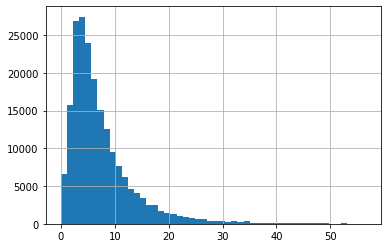

In [47]:
# Разница между первой и последней транзакцией клиента
df_extr_features['transaction_delta'] = (df_extr_features[('transaction_datetime','max')]\
                                         - df_extr_features[('transaction_datetime','min')]).dt.days

# Средняя периодичность покупок
df_extr_features['transaction_period'] = df_extr_features['transaction_delta'] / df_extr_features[('transaction_count','count')]

df_extr_features['transaction_period'].hist(bins=50)

In [48]:
# Переименум колонки
df_extr_features.columns = [
    'transaction_count',
    'netto',
    'is_own_trademark',
    'is_alcohol',
    'client_id',
    'transaction_datetime_min',
    'transaction_datetime_max',
    'transaction_delta',
    'transaction_period'
]
df_extr_features.head()

,transaction_count,netto,is_own_trademark,is_alcohol,client_id,transaction_datetime_min,transaction_datetime_max,transaction_delta,transaction_period
client_id,,,,,,,,,
000012768d,4,7.023000,4,0,4,2018-12-01 07:12:45,2019-03-14 15:01:47,103,25.750000
000036f903,32,2.439500,14,1,32,2018-11-28 10:48:36,2019-03-17 10:29:37,108,3.375000
00010925a5,18,2.667389,9,1,18,2018-11-25 10:56:18,2019-03-08 07:09:50,102,5.666667
0001f552b0,15,2.774067,10,0,15,2018-11-24 07:14:43,2019-03-16 10:54:02,112,7.466667
00020e7b18,18,7.286222,44,0,18,2018-11-23 08:21:26,2019-03-15 12:04:23,112,6.222222


**Вывод:** Дополнительные признаки сформированы.

### 2.3. Формирование выборок.

На данном этапе объединим полученные признаки в один датасет и выделим тренировочную, валидационную и тестовую выборки.


In [49]:
# Перечень признаков используемых для обучения модели
features = [
 'age',
 'gender',
#  'week_0',
 'week_1',
 'week_2',
 'week_3',
 'week_4',
 'week_5',
 'week_6',
 'week_7',
 'week_8',
 'week_9',
 'week_10',
 'week_11',
#  'week_12',
#  'week_13',
#  'week_14',
#  'week_15',
#  'week_16',
#  'week_17',
 'mean',
#     'netto', 
#     'is_own_trademark', 
    'is_alcohol',
#     'transaction_count',
#     'transaction_delta',
#     'transaction_period',
    'first_issue_time',
    'first_redeem_time',
    'issue_redeem_delay',
]

In [50]:
# Объединение таблиц в один набор данных
df_clients = df_client.set_index("client_id").merge(df_shift, how='left', left_index=True, right_index=True)
df_clients = df_clients.merge(df_extr_features, how='left', left_index=True, right_index=True)

# Перечень клиентов для трейна
df_train = df_train_list.set_index("client_id")
# Перечень клиентов для теста
indices_test = df_test_list["client_id"].values

# Формирование окончательного набора данных
df_features = df_clients[features].copy()
# Разделим трейн на обучающую и валидационную выборки
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

In [51]:
# from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler, Normalizer, KBinsDiscretizer

# scaler = KBinsDiscretizer ()
# df_features = pd.DataFrame(data=scaler.fit_transform(df_features), columns=df_features.columns, index=df_features.index)

In [52]:
# Тренировачная выборка
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'purchased']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

# Валидационная выборка
X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'purchased']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

# Полная тренировочная выборка
X_train_full = df_features.loc[df_train.index, :]
y_train_full = df_train.loc[:, 'purchased']
treat_train_full = df_train.loc[:, 'treatment_flg']

# Тестовая выборка
X_test = df_features.loc[indices_test, :]

# Датасет для результатов
models_results = pd.DataFrame({
    'method':[],
    'model': [],
    'uplift': []
})

# Проверка размеров выборок
pd.DataFrame({
    'X_train':X_train.shape,
    'X_val':X_val.shape,
    'X_test':X_test.shape

})

,X_train,X_val,X_test
0,98018,42009,60012
1,18,18,18


**Вывод:** Сформировали выборки для обучения модели, её валидации и тестирования.

**Вывод по разделу**

В данном раздели произвели предобработку данных, извлечение признаков и сформировали выборки для дальнейшей работы. Опытным путём был определён окончательный набор признаков:
1. Признаки временных рядов: суммарные траты клиентов за неделю с 1 по 11, средняя сумма трат за все недели.
2. Признаки данных о клиенте: пол, возраст, дата регистрации, первой покупки и разница между ними.
3. Признаки на основе данных о покупках: количество купленного алкоголя.

## 3. Построение модели машинного обучения.

В целом, решение поставленной задачи сводится к определению величины `uplift` для каждого клиента из тестового набора. То есть необходимо определить на сколько изменится вероятность покупки клиентом после воздействия на него. Существует несколько подходов к решению данной задачи:
- Одна модель с признаком коммуникации;
- Одна модель с трансформацией классов;
- Две независимые модели;
- Две зависимые модели

Выбор подхода будем осуществлять исходя из полученных результатов при каждом из них на валидационной выборке. Для решения задачи применялись следующие модели машинного обучения:
- LGBMClassifier
- CatBoostClassifier
- RandomForestClassifier

Процесс подбора гиперпараметров к данным моделям я описывать не вижу смысла, так как они, по большей части, подбирались в ручную. Отмечу что наибольшую эффективность показывали модели с "загрублёнными" гиперпараметрами: глубина дерева - не более трёх, количество деревьев - не более 70, количество итераций катбуста - 20.

In [53]:
# Для удобства создадим функцию
def get_uplift_score(model):
    """ Принимаем модель
        Возвращаем uplift score
    """
    model.fit(X_train, y_train, treat_train)
    uplift = model.predict(X_val)
    return uplift_at_k(y_true=y_val, uplift=uplift, treatment=treat_val, strategy='by_group')

### 3.1. Одна модель с признаком коммуникации

Модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомый uplift.


In [54]:
# Получаем результаты решения данного подхода на трёх разных моделях и сохраняем их в датафрейм
sm_results = pd.DataFrame({
    'method':['SoloModel'] * 3,
    'model':['LGBM', 'CatBoost', 'RandomForest'],
    'uplift':[get_uplift_score(SoloModel(LGBMClassifier(max_depth=2, 
                                                        subsample=0.35, 
                                                        random_state=42
                                                       ))),
              get_uplift_score(SoloModel(CatBoostClassifier(max_depth=2,
                                                            iterations=20, 
                                                            thread_count=2, 
                                                            random_state=42, 
                                                            silent=True
                                                           ))),
              get_uplift_score(SoloModel(RandomForestClassifier(n_estimators=75,
                                                                max_depth=3,
                                                                random_state=42
                                                               )))
        
    ]
})
sm_results

,method,model,uplift
0,SoloModel,LGBM,0.062853
1,SoloModel,CatBoost,0.057989
2,SoloModel,RandomForest,0.019130


In [55]:
# Запишем результаты
models_results = pd.concat([models_results, sm_results])

**Вывод:** Данныая модель показывает аплифт 0.063. Данное значение удалось получить с применением модели LGBMClassifier.

### 3.2 Трансформация классов

Данный подход основан на преобразовании, по сути, двух таргетов в один и обучении одной модели машинного обучения на данных с изменённой целевой переменной.


In [56]:
# Получаем результаты решения данного подхода на трёх разных моделях и сохраняем их в датафрейм
ct_results = pd.DataFrame({
    'method':['ClassTransformation'] * 3,
    'model':['LGBM', 'CatBoost', 'RandomForest'],
    'uplift':[get_uplift_score(ClassTransformation(LGBMClassifier(max_depth=2, 
                                                                  subsample=0.35, 
                                                                  random_state=42
                                                                 ))),
              get_uplift_score(ClassTransformation(CatBoostClassifier(max_depth=2,
                                                                      iterations=20, 
                                                                      thread_count=2, 
                                                                      random_state=42, 
                                                                      silent=True
                                                                     ))),
              get_uplift_score(ClassTransformation(RandomForestClassifier(n_estimators=50,
                                                                max_depth=3,
                                                                random_state=12345
                                                               )))
        
    ]
})
ct_results

,method,model,uplift
0,ClassTransformation,LGBM,0.081996
1,ClassTransformation,CatBoost,0.081786
2,ClassTransformation,RandomForest,0.091370


In [57]:
# Запишем результаты
models_results = pd.concat([models_results, ct_results])

**Вывод:** В данном подходе удалось достичь показателя аплифт равного 0.091. Наилучшее качество показала модель RandomForestClassifier.

### 3.3. Две независимые модели

Подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно.

In [58]:
# Получаем результаты решения данного подхода на трёх разных моделях и сохраняем их в датафрейм
tm_results = pd.DataFrame({
    'method':['TwoModels'] * 3,
    'model':['LGBM', 'CatBoost', 'RandomForest'],
    'uplift':[get_uplift_score(TwoModels(estimator_trmnt=LGBMClassifier(max_depth=2, subsample=0.35, random_state=42), 
                                         estimator_ctrl=LGBMClassifier(max_depth=2, subsample=0.35, random_state=42), 
                                         method='vanilla'
                                        )),
              get_uplift_score(TwoModels(estimator_trmnt=CatBoostClassifier(max_depth=2, 
                                                                            iterations=20, 
                                                                            thread_count=2, 
                                                                            random_state=42,
                                                                            silent=True
                                                                           ), 
                                         estimator_ctrl=CatBoostClassifier(max_depth=2, 
                                                                           iterations=20, 
                                                                           thread_count=2, 
                                                                           random_state=42,
                                                                           silent=True
                                                                          ),  
                                         method='vanilla'
                                        )),
              get_uplift_score(TwoModels(estimator_trmnt=RandomForestClassifier(n_estimators=75, max_depth=3, random_state=42), 
                                         estimator_ctrl=RandomForestClassifier(n_estimators=75, max_depth=3, random_state=42), 
                                         method='vanilla'
                                        ))
    ]
})
tm_results

,method,model,uplift
0,TwoModels,LGBM,0.075469
1,TwoModels,CatBoost,0.071861
2,TwoModels,RandomForest,0.055777


In [59]:
# Запишем результаты
models_results = pd.concat([models_results, tm_results])

**Вывод:** Удалось достичь значения аплифта 0.075 с моделью LGBMClassifier.

### 3.4. Две зависимые модели

Идея состоит в том, что В начале мы обучаем классификатор по контрольным данным, затем используем предсказания в качестве нового признака для обучения второго классификатора на тестовых данных.

In [60]:
# Получаем результаты решения данного подхода на трёх разных моделях и сохраняем их в датафрейм
tm_ddr_results = pd.DataFrame({
    'method':['TwoModels_ddr_treatment'] * 3,
    'model':['LGBM', 'CatBoost', 'RandomForest'],
    'uplift':[get_uplift_score(TwoModels(estimator_trmnt=LGBMClassifier(max_depth=2, subsample=0.35, random_state=42), 
                                         estimator_ctrl=LGBMClassifier(max_depth=2, subsample=0.35, random_state=42), 
                                         method='ddr_treatment'
                                        )),
              get_uplift_score(TwoModels(estimator_trmnt=CatBoostClassifier(max_depth=2, 
                                                                            iterations=20, 
                                                                            thread_count=2, 
                                                                            random_state=42,
                                                                            silent=True
                                                                           ), 
                                         estimator_ctrl=CatBoostClassifier(max_depth=2, 
                                                                           iterations=20, 
                                                                           thread_count=2, 
                                                                           random_state=42,
                                                                           silent=True
                                                                          ),  
                                         method='ddr_treatment'
                                        )),
              get_uplift_score(TwoModels(estimator_trmnt=RandomForestClassifier(n_estimators=75, max_depth=3, random_state=42), 
                                         estimator_ctrl=RandomForestClassifier(n_estimators=75, max_depth=3, random_state=42), 
                                         method='ddr_treatment'
                                        ))
    ]
})
tm_ddr_results

,method,model,uplift
0,TwoModels_ddr_treatment,LGBM,0.046687
1,TwoModels_ddr_treatment,CatBoost,0.043646
2,TwoModels_ddr_treatment,RandomForest,0.048202


In [61]:
# Запишем результаты
models_results = pd.concat([models_results, tm_ddr_results])

In [62]:
# Получаем результаты решения данного подхода на трёх разных моделях и сохраняем их в датафрейм
tm_ctrl_results = pd.DataFrame({
    'method':['TwoModels_ddr_control'] * 3,
    'model':['LGBM', 'CatBoost', 'RandomForest'],
    'uplift':[get_uplift_score(TwoModels(estimator_trmnt=LGBMClassifier(max_depth=2, subsample=0.35, random_state=42), 
                                         estimator_ctrl=LGBMClassifier(max_depth=2, subsample=0.35, random_state=42), 
                                         method='ddr_control'
                                        )),
              get_uplift_score(TwoModels(estimator_trmnt=CatBoostClassifier(max_depth=2, 
                                                                            iterations=20, 
                                                                            thread_count=2, 
                                                                            random_state=42,
                                                                            silent=True
                                                                           ), 
                                         estimator_ctrl=CatBoostClassifier(max_depth=2, 
                                                                           iterations=20, 
                                                                           thread_count=2, 
                                                                           random_state=42,
                                                                           silent=True
                                                                          ),  
                                         method='ddr_control'
                                        )),
              get_uplift_score(TwoModels(estimator_trmnt=RandomForestClassifier(n_estimators=75, max_depth=3, random_state=42), 
                                         estimator_ctrl=RandomForestClassifier(n_estimators=75, max_depth=3, random_state=42), 
                                         method='ddr_control'
                                        ))
    ]
})
tm_ctrl_results

,method,model,uplift
0,TwoModels_ddr_control,LGBM,0.069735
1,TwoModels_ddr_control,CatBoost,0.069183
2,TwoModels_ddr_control,RandomForest,0.051390


In [63]:
# Запишем результаты
models_results = pd.concat([models_results, tm_ctrl_results])

**Вывод:** Подходы с зависимыми моделями показывают качество не более 0.07.

### 3.5. Выбор модели

Исходя из результатов полученых на валидации, выберем подход к решению задачи и модель машинного обучения.

In [64]:
models_results.sort_values(by='uplift', ascending=False)

,method,model,uplift
2,ClassTransformation,RandomForest,0.091370
0,ClassTransformation,LGBM,0.081996
1,ClassTransformation,CatBoost,0.081786
0,TwoModels,LGBM,0.075469
1,TwoModels,CatBoost,0.071861
0,TwoModels_ddr_control,LGBM,0.069735
1,TwoModels_ddr_control,CatBoost,0.069183
0,SoloModel,LGBM,0.062853
1,SoloModel,CatBoost,0.057989
2,TwoModels,RandomForest,0.055777


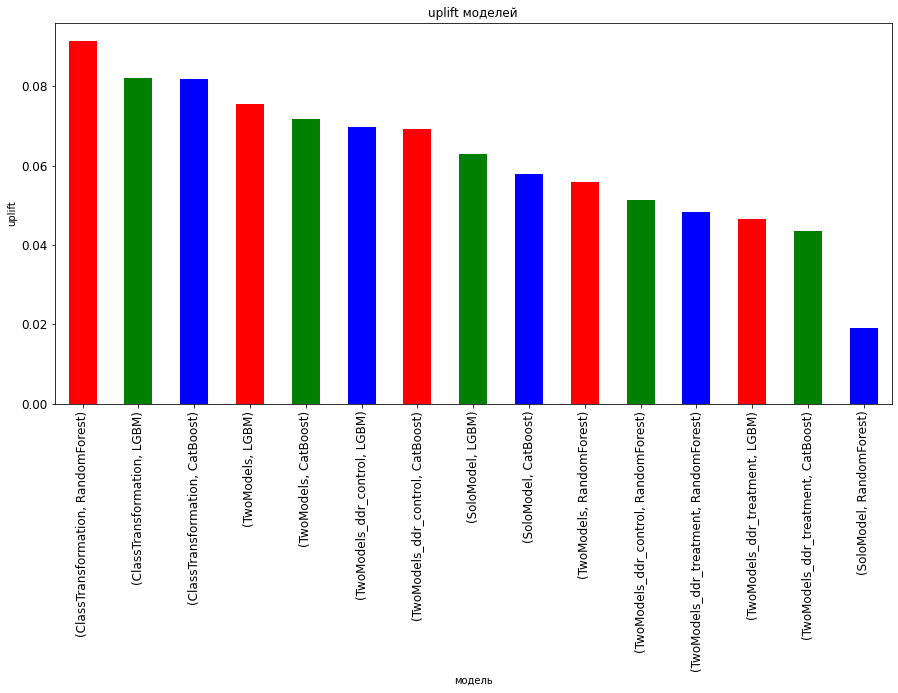

In [65]:
# Визуализация результатов
models_results.set_index(['method', 'model'])\
    .sort_values(by='uplift', ascending=False)['uplift'].plot(kind='bar',
                                                              figsize=(15,7),
                                                              fontsize=12,
                                                              title='uplift моделей',
                                                              xlabel='модель',
                                                              ylabel='uplift',
                                                              color=['r', 'g', 'b']
                                                             );

**Вывод:** Наибольшее значение uplift удаётся получить с помощью трансформации классов и применении модели RandomForestClassifier. Стоит отметить, что так как значения uplift очень малы (не более 0.1), то на результаты решения влияют прежде всего такие гиперпараметры как максимальная глубина дерева(для бустингов = 2, для случайного леса = 3), количество итераций для CatBoost - не более 50, и да же random_state.

**Вывод по разделу**

В данном разделе был осуществлён выбор подхода к определению аплифта и выбор модели машинного обучения. Наибольшую эффективность показал подход с трансформацией целевых классов в один класс. Применительно к данному подходу, наибольшее качество показала модели машинного обучения RandomForestClassifier.


## 4. Тестирование модели 

- Протестируем модель на тестовой выборке;
- Произведём оценку важности признаков.

### 4.1. Тестирование модели на тестовой выборке

Наилучшее качество показал подход к определению uplift с помощью трансформации классов и применении модели RandomForestClassifier.
Обучим данную модель на полной тренировочной выборке и сформируем файл с данными для отправки решения. Так как в постановке задачи указано, что необходимо пометить `1` тех клиентов, которым стоит отправлять СМС, к значению аплифта для каждого клиента прибавим 0.5. Таким образом при положительном значении аплифта клиент будет помечен `1`, а при отрицательном `0`.

In [66]:
# Модель
ct_full = ClassTransformation(RandomForestClassifier(n_estimators=50,
                                                     max_depth=3,
                                                     random_state=12345
                                                    ))
# Обучение модели
ct_full = ct_full.fit(
    X_train_full, 
    y_train_full, 
    treat_train_full
)
# Получаем uplift для каждого клиента
X_test.loc[:, 'uplift'] = ct_full.predict(X_test)
# Получаем вероятность посылать или нет СМС
X_test['pred'] = X_test['uplift'] + 0.5
# Формируем файл с результатами
sub = X_test[['pred']].to_csv('submission.csv', index_label='client_id')

!head -n 5 submission.csv

client_id,pred
a9a604ed6e,0.5349953800859759
ebd7360016,0.5485412933021936
908cd9b8e8,0.5313548610486318
dceb8ce861,0.5232926077606463


**Вывод:** На открытой части тестовой выборки удалось получить качество 0.0521

### 4.2. Оценка важности признаков

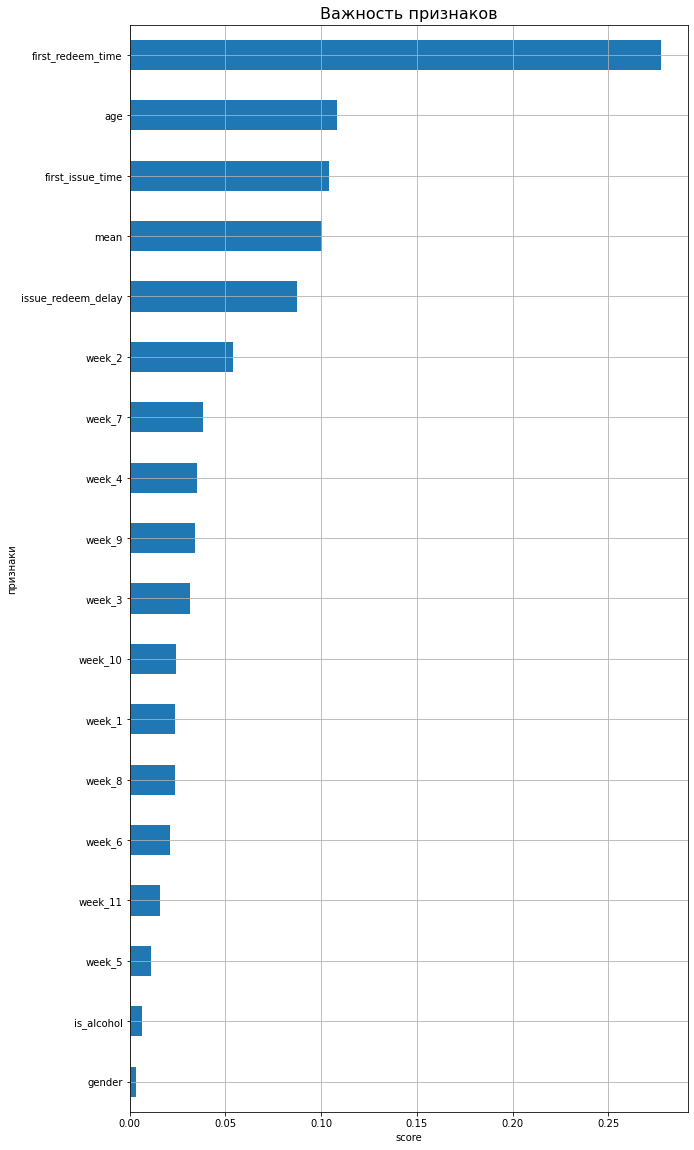

In [67]:
# Выделим признаки
efectiv_score = pd.DataFrame(data={'score': ct_full.estimator.feature_importances_}, 
                            index=X_train.columns).sort_values(by='score')
# Выведем их на экран
ax = efectiv_score.plot(kind='barh', grid=True, figsize=(10,20), legend=False)
ax.set_title("Важность признаков", fontsize=16)
ax.set_ylabel("признаки")
ax.set_xlabel("score")
plt.show;

**Вывод:** Наибольший вклад в результат решения задачи вносит дата первой покупки, затем возраст покупателя, время регистрации, средняя сумма трат за неделю и время между регистрацией и первой покупкой. Далее идут признаки покупок по неделям, и в конце количество купленного алкоголя и пол клиента.

**Вывод по разделу**

Произвели тестирование модели с результатом на открытой части тестового набора данных = 0.0521, что является давольно не плохим результатом. Оценили важность признаков. Оказалось, что самыми важными признаками являются дата первой покупки и возраст покупателя.


## Вывод

Была поставлена задача определить перечень клиентов которым необходимо разослать СМС с целью побудить их к покупке в нашем магазине. Для этого необходимо было определить величину uplift для каждого клиента, и тем у кого эта величина окажется положительное - отправить СМС. Задача решалась в четыре этапа:

**1.** На первом этапе была выполнена загрузка данных и их первичный анализ. Были выявлены проблемные вопросы в данных и обозначены пути их решения. Анализ данных показал, что мы имеем дело с данными о клиентах магазина, товарах и совершаемых покупках. Также, в наборе данных имеются данные о воздействии на покупателей и реакции на неё среди клиентов входящих в тренировочную выборку.

**2.** Далее, была произведёна предобработка данных, извлечение признаков и подготовка выборок к обучению моделей. В ходе предобработки устранили выявленные на первом этапе проблемы в данных - пропуски и недостоверные данные. Извлечение признаков производилось в двух направлениях - с помощью перехода от данных об отдельных покупках к данным по еженедельным тратам и с помощью агрегации некоторых признаков. По результатам преобразования данных был получен итоговый набор данных состоящий из 18 признаков. И в конце второго раздела итоговый датасет был разделён на три выборки: тренировочную, валидационную и тестовую.

**3.** На третьем этапе произвели выбор подхода к определению аплифта и выбор оптимальной модели машинного обучения. Наибольшее значение аплифта удалось получить с помощью подхода с трансформацией классой. В данном подходе целевая переменная, которая, по сути, была представлена в виде двух колонок(факт воздействия и факт покупки) преобразуется в один признак по принципу логического "И". Сложность выбора модели и подбора гиперпараметров заключалас в том, что значение аплифта было очень небольшим(не больше 0.1), а от этого данные сильно "шумели", приходилось сильно загрублять модели и даже немного подбирать random_state. В итоге выбор пал на модель RandomForestClassifier с глубиной дерева = 3 и количеством деревьев = 50.

**4.** Тестирование модели показало метрику качества Gini = 0.0521. Анализ важность признаков показал что самыми важными признаками являются дата первой покупки и возраст покупателя.

